# Summarize Runs
Find the best model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import shutil
import json

Configuration

In [2]:
prop, level = 'ip', 'mopac_pm7-acn-adiabatic'

## Gather outputs from runs
Get the configuration and test summary

In [3]:
complete_runs = [x.parent for x in Path('runs').glob('*/test_summary.json')]
print(f'Found {len(complete_runs)} completed runs')

Found 12 completed runs


In [4]:
def load_summary(path: Path) -> dict:
    """Load the summary of the run configuration and parameters
    
    Args:
        path: Path to the run
    Returns:
        Summary of inputs and results
    """
    
    # Load the configuration and summary
    output = {'path': path, 'starting_model': path.parent.name}
    output.update(json.loads((path / 'params.json').read_text()))
    output.update(json.loads((path / 'test_summary.json').read_text()))
    output['level_count'] = len(output['lower_levels'])
    return output

Gather results and sort by the error with no data available about the molecule (most common case in our pipelines)

In [5]:
summary = pd.DataFrame(map(load_summary, complete_runs)).sort_values('level_0_mean_absolute_error')
summary.head()

,path,starting_model,atom_features,message_steps,output_layers,reduce_op,atomwise,num_epochs,batch_size,lower_levels,...,level_2_mean_absolute_error,level_2_r2_score,level_2_mean_squared_error,level_1_mean_absolute_error,level_1_r2_score,level_1_mean_squared_error,level_0_mean_absolute_error,level_0_r2_score,level_0_mean_squared_error,level_count
11,runs/f=32-T=4-r=sum-atomwise=True-hash=1ecebdc7,runs,32,4,"[64, 32, 32]",sum,True,512,32,[mopac_pm7-acn-vertical],...,NaN,NaN,NaN,0.105263,0.858723,0.026677,0.144791,0.753972,0.046456,1
4,runs/f=32-T=4-r=sum-atomwise=True-hash=d649559e,runs,32,4,"[64, 32, 32]",sum,True,512,32,[],...,NaN,NaN,NaN,NaN,NaN,NaN,0.145819,0.753890,0.046472,0
2,runs/f=64-T=4-r=sum-atomwise=True-hash=da95d3d1,runs,64,4,"[64, 32, 32]",sum,True,512,32,[],...,NaN,NaN,NaN,NaN,NaN,NaN,0.145988,0.748820,0.047429,0
3,runs/f=32-T=4-r=sum-atomwise=True-hash=4732898b,runs,32,4,"[64, 32, 32]",sum,True,512,32,[xtb-vertical],...,NaN,NaN,NaN,0.150060,0.749997,0.047207,0.149934,0.747113,0.047752,1
1,runs/f=32-T=4-r=sum-atomwise=True-hash=2b12193a,runs,32,4,"[64, 32, 32]",sum,True,512,32,"[xtb-vertical, xtb-acn-adiabatic, mopac_pm7-ve...",...,0.15136,0.744311,0.048281,0.154532,0.742743,0.048577,0.153308,0.742789,0.048568,3


Get the best model when predicting the target output and no data are available

In [7]:
to_eval = summary.query(f'property=="{prop}" and level=="{level}"')
best = to_eval.sort_values('level_0_mean_squared_error').iloc[0]
best

path                           runs/f=32-T=4-r=sum-atomwise=True-hash=1ecebdc7
starting_model                                                            runs
atom_features                                                               32
message_steps                                                                4
output_layers                                                     [64, 32, 32]
reduce_op                                                                  sum
atomwise                                                                  True
num_epochs                                                                 512
batch_size                                                                  32
lower_levels                                          [mopac_pm7-acn-vertical]
property                                                                    ip
level                                                  mopac_pm7-acn-adiabatic
train_counts                                        

## Learning Curve
Figure out if we've completly converged wrt to number of epochs

In [8]:
log = pd.read_csv(best.path / 'log.csv')

Text(0, 0.5, 'Loss')

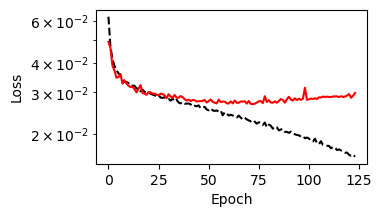

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogy(log.index, log['loss'], '--k')
ax.semilogy(log.index, log['val_loss'], '-r')


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

Early stopping is working!

## Plot the predicted vs actual
See if there are significant outliers, etc

In [10]:
test_data = pd.read_csv(best.path / 'test_results.csv')
print(f'Loaded {len(test_data)} test records')

Loaded 10490 test records


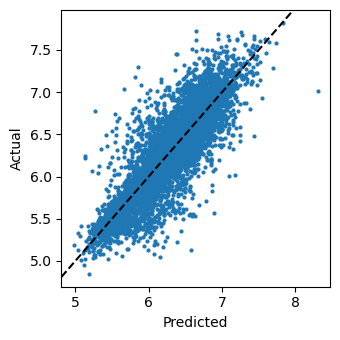

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['level_0-pred'], test_data['true'], s=4)

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig.tight_layout()

## Show the effect of adding levels
The error should go down the more information we have about the molecule

In [12]:
n_levels = len(best['train_counts'])
print(f'Displaying results with {n_levels} levels of data: {best["lower_levels"]}')

Displaying results with 2 levels of data: ['mopac_pm7-acn-vertical']


Show the MAE as a function of level

Text(0, 0.5, 'MAE (V)')

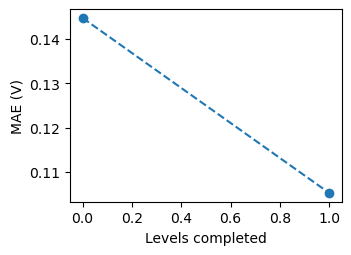

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

maes = [best[f'level_{i}_mean_absolute_error'] for i in range(n_levels)]
ax.plot(maes, '--o')

ax.set_xlabel('Levels completed')
ax.set_ylabel('MAE (V)')

Plot predicted-vs-actual for each level

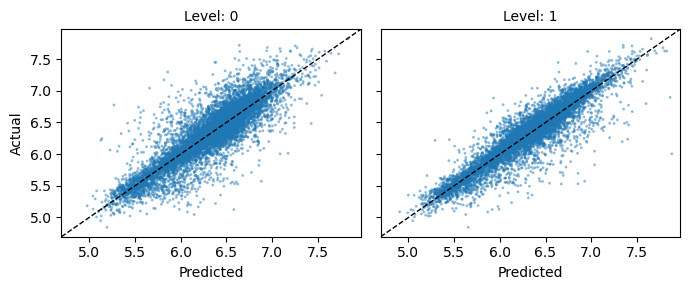

In [14]:
fig, axs = plt.subplots(1, n_levels, figsize=(3.5 * n_levels, 3.), sharey=True, sharex=True)

for level, ax in enumerate(axs):
    ax.scatter(test_data[f'level_{level}-pred'], test_data['true'], s=4, edgecolor='none', alpha=0.5)
    ax.set_title(f'Level: {level}', fontsize=10)
    ax.set_xlabel('Predicted')
    
# Add the y=x line
for ax in axs:
    ax.set_xlim(ax.get_ylim())
    ax.set_ylim(ax.get_ylim())
    
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)


axs[0].set_ylabel('Actual')
fig.tight_layout()

## Save the top models
Get the path to the best model for each property, save a link to it

In [15]:
best_dir = Path("best_models")
if best_dir.is_dir():
    shutil.rmtree(best_dir)
best_dir

PosixPath('best_models')

In [16]:
for (prop, level), group in summary.groupby(['name', 'level']):
    (best_dir / prop).mkdir(exist_ok=True, parents=True)
    best = group.sort_values('level_0_mean_absolute_error', ascending=True).iloc[0]
    print(f'Best for {prop}/{level}: {best.path}')
    out_dir = best_dir / prop / level
    out_dir.symlink_to(best.path.absolute())

Best for oxidation_potential/mopac_pm7-acn-adiabatic: runs/f=32-T=4-r=sum-atomwise=True-hash=1ecebdc7
